# Weather Data
### by Line van Nifterik and Stoil Iliev

Packages:

In [1]:
!pip install numpy pandas matplotlib seaborn scikit-learn scipy haversine networkx

Imports:

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import haversine
import networkx as nx
import seaborn as sns
from scipy.linalg import eigh, eig
import sklearn
import scipy
import warnings
warnings.filterwarnings('ignore')

In [37]:
class WeatherGraphProcessor:
  def __init__(self, stations_file="weather_stations.csv", data_file="weather_data.csv"):
    self.stations_df = None
    self.weather_df = None
    self.start_date = None
    self.load_data(stations_file, data_file)
    self.GWS = None # Weather station graph
    self.eigenvalues = None
    self.eigenvects = None
    self.G_P = None

  def load_data(self, stations_file, data_file):
    try:
      # Load weather station data
      self.stations_df = pd.read_csv(stations_file)
      print(f"Loaded {len(self.stations_df)} weather stations")

      # Load weather measurement data
      self.weather_df = pd.read_csv(data_file, index_col=False)
      # Convert 'DATE' column to datetime objects
      self.weather_df['DATE'] = pd.to_datetime(self.weather_df['DATE'])
      print(f"Loaded {len(self.weather_df)} weather measurements")
      self.start_date = self.weather_df['DATE'].min()

      # Display basic info
      print("\nWeather stations columns:", list(self.stations_df.columns))
      print("Weather data columns:", list(self.weather_df.columns))
      print(f"Date range: {self.weather_df['DATE'].min()} to {self.weather_df['DATE'].max()}")

    except FileNotFoundError:
      print("File not found")

  def construct_weather_station_graph(self, alpha, beta, sparsification, k, threshold):
    # alpha: distance decay
    # beta: alt diff decay
    # sparsification: knn, threshold, none?
    # k: kNN number
    # threshold: for weight-based sparisification

    n_stations = len(self.stations_df)
    W = np.zeros((n_stations, n_stations))

    # get coordinates / altitudes
    lats = self.stations_df['LAT'].values
    lons = self.stations_df['LONG'].values
    heis = self.stations_df['HEI'].values

    # Compute pairwise distances
    for i in range(n_stations):
      for j in range(n_stations):
        if i != j:
          # Geographic
          d_ij = haversine.haversine((lats[i], lons[i]), (lats[j], lons[j]), unit=haversine.Unit.KILOMETERS)
          # Altitude difference
          h_ij = abs(heis[i] - heis[j]) / 1000  # Convert to km
          # Weight function
          W[i, j] = np.exp(-alpha * d_ij - beta * h_ij)

    # sparsification
    if sparsification == 'knn':
      # k-NN
      W_sparse = np.zeros_like(W)
      for i in range(n_stations):
        neighbors = np.argsort(W[i, :])[-k-1:-1] # Exclude self (highest weight)
        W_sparse[i, neighbors] = W[i, neighbors]
      # Make symmetric (mutual k-NN)
      W =(W_sparse + W_sparse.T) / 2

    elif sparsification == 'threshold':
      W[W < threshold] = 0

    # Store the graph
    self.GWS = W

    # Compute graph Laplacian and its eigendecomposition
    D = np.diag(np.sum(W, axis=1))
    L = D - W  # Combinatorial Laplacian

    # Compute eigenvalues and eigenvectors
    self.eigenvals, self.eigenvecs = eigh(L)

    print(f"Constructed weather station graph with {n_stations} nodes")
    print(f"Sparsification: {sparsification}, Non-zero edges: {np.sum(W > 0)}")
    print(f"Graph density: {np.sum(W > 0) / (n_stations * (n_stations - 1)):.3f}")

    return W

  def draw_weather_station_graph(self):
    if self.GWS is None:
      print("Weather station graph not constructed yet.")
      return

    G = nx.from_numpy_array(self.GWS)

    # Get positions for nodes (using station coordinates)
    pos = {i: (self.stations_df['LONG'][i], self.stations_df['LAT'][i]) for i in range(len(self.stations_df))}

    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, node_size=10, width=0.1)
    plt.title("Weather Station Graph")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

  def construct_path_graph(self, time_steps): # 34 for nb of months between start and end
    self.G_P = nx.path_graph(time_steps)

Applying spectral filtering on the spatio-temporal graph and visualizing the filtered signal for a specific time period.

Loaded 76 weather stations
Loaded 40921 weather measurements

Weather stations columns: ['ID', 'SITE', 'LAT', 'LONG', 'HEI', 'OP']
Weather data columns: ['ID', 'DATE', 'QUALITY', 'MIN_5CM', 'MIN_2M', 'MEAN_2M', 'MAX_2M', 'REL_HUMIDITY', 'MEAN_WIND_STRENGTH', 'MAX_WIND_SPEED', 'SUNSHINE', 'MEAN_CLOUDINESS', 'PRECIPITATION', 'MEAN_PRESSURE']
Date range: 2018-09-08 00:00:00 to 2021-06-13 00:00:00
Constructed weather station graph with 76 nodes
Sparsification: knn, Non-zero edges: 400
Graph density: 0.070


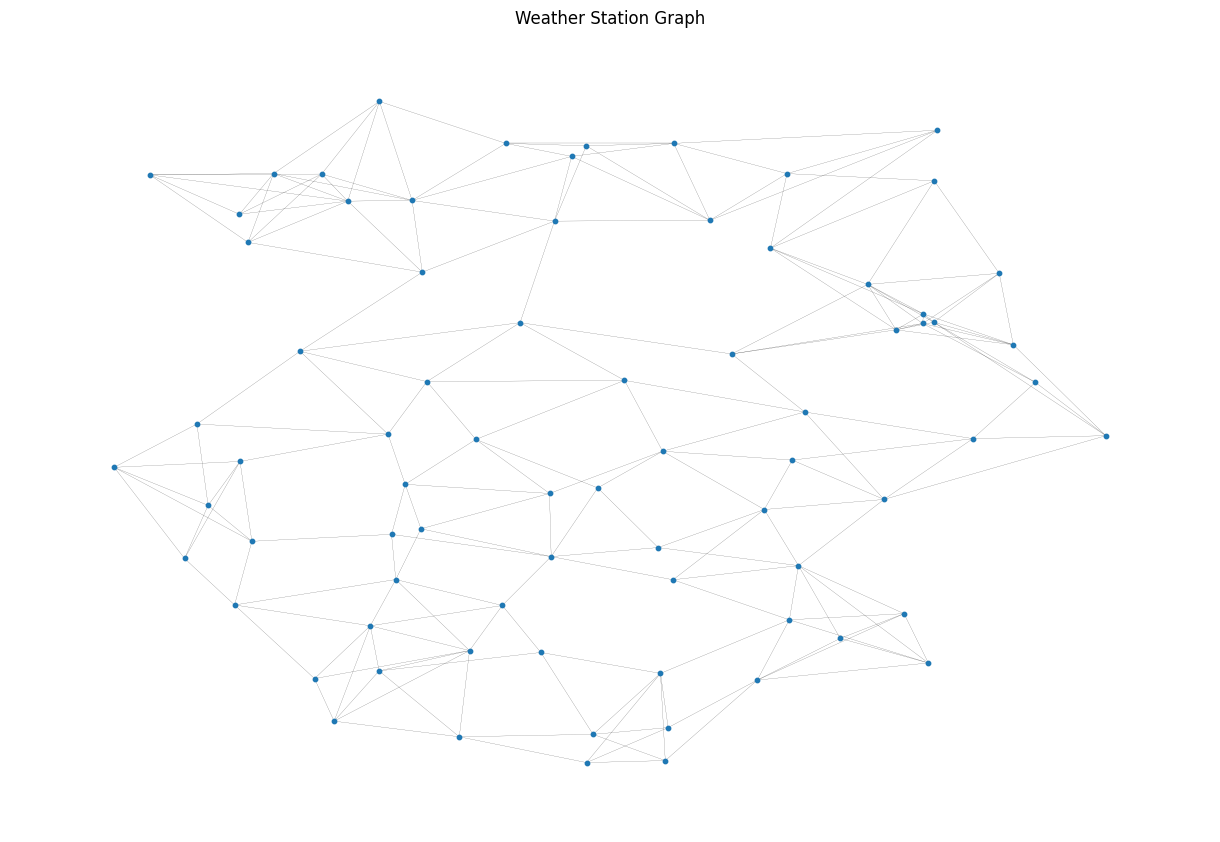

In [4]:
# Instantiate the WeatherGraphProcessor
weather_processor = WeatherGraphProcessor()

# Construct the weather station graph
# k-NN
weather_processor.construct_weather_station_graph(alpha=0.1, beta=0.001, sparsification="knn", k = 4, threshold=0.00001)
# Threshold
# weather_processor.construct_weather_station_graph(alpha=0.1, beta=0.001, sparsification='threshold', threshold=0.00001)

# Draw the graph
weather_processor.draw_weather_station_graph()

In [5]:
weather_processor.construct_path_graph(34)

In [6]:
weather_processor.weather_df.head(5)

,ID,DATE,QUALITY,MIN_5CM,MIN_2M,MEAN_2M,MAX_2M,REL_HUMIDITY,MEAN_WIND_STRENGTH,MAX_WIND_SPEED,SUNSHINE,MEAN_CLOUDINESS,PRECIPITATION,MEAN_PRESSURE
0,102,2019-12-12,3.0,NaN,3.3,4.9,5.8,87.54,10.1,17.9,3.433,NaN,NaN,992.46
1,102,2019-12-13,3.0,NaN,2.0,2.7,3.7,86.08,10.7,21.0,0.017,NaN,NaN,976.26
2,102,2019-12-14,3.0,NaN,3.6,5.4,6.6,88.67,14.1,26.6,1.667,NaN,NaN,979.45
3,102,2019-12-15,3.0,NaN,4.4,6.3,8.1,81.38,16.3,30.4,4.850,NaN,NaN,989.41
4,102,2019-12-16,3.0,NaN,5.3,6.5,7.9,89.58,9.2,16.3,0.167,NaN,NaN,999.68


In [7]:
# def get_A(G):
#     A = nx.adjacency_matrix(G)
#     A = A.astype('float')
#     return(A)

# def get_norm_L(G):
#     L = nx.normalized_laplacian_matrix(G, weight=None)
#     L = L.astype('float')
#     return(L)

In [8]:
def construct_spacetime_graph(self):
  if self.GWS is None:
    raise ValueError("Must construct weather station graph first")

  n_stations = self.GWS.shape[0]

  # # Create path graph for time (adjacency matrix)
  # A_GP = np.zeros((time_steps, time_steps))
  # for i in range(time_steps - 1):
  #   A_GP[i, i+1] = 1
  #   A_GP[i+1, i] = 1

  A_GP = nx.to_numpy_array(self.G_P, dtype=float)

  # Kronecker product: A_GWS (x) I_t + I_n (x) A_GP
  time_steps = self.G_P.number_of_nodes()
  I_t = np.eye(time_steps)
  I_n = np.eye(n_stations)

  G_time_WS = np.kron(self.GWS, I_t) + np.kron(I_n, A_GP)

  print(f"Constructed spatio-temporal graph with {n_stations * time_steps} nodes")
  return G_time_WS

In [9]:
G_time_WS = construct_spacetime_graph(weather_processor)

Constructed spatio-temporal graph with 2584 nodes


In [10]:
def date_to_period_id(self, date):
    start_date = self.start_date
    print(date, start_date)
    if isinstance(start_date, str):
        start_date = pd.to_datetime(start_date)
    if isinstance(date, str):
        date = pd.to_datetime(date)
    time_period_id = (date.year-start_date.year) * 12 + (date.month-start_date.month)
    return time_period_id

In [11]:
def period_id_to_time_period(self, period_id):
    start_date = self.start_date
    t1 = start_date + pd.DateOffset(months=period_id)
    t2 = t1 + pd.DateOffset(months=1)
    print(t1, t2)

In [12]:
def node_to_signal(self, id_station, time_id, measurement): # measurement we are interested in, e.g. MEAN_2M
    start_date = self.start_date
    df_weat = self.weather_df
    t1 = start_date + pd.DateOffset(months=time_id)
    t2 = t1 + pd.DateOffset(months=1)
    filtered_df = df_weat[(df_weat['DATE'] >= t1)
                          & (df_weat['DATE'] < t2)
                          & (df_weat['ID']==id_station)]
    signal_sc = filtered_df[measurement].mean()
    return signal_sc

# Note: If we want all measurements at once (like multiple columns), we can extend measurement to be a list of column names:
# signal_vec = filtered_df[measurement].to_numpy()
# e.g. measurement = ["MEAN_2M", "PRECIPITATION"] -> then signal_vec will be a 2D array (days × variables).

In [13]:
def get_signal_for_one_id(self, station_id, measurement):
    L=[]
    time_steps = self.G_P.number_of_nodes()
    for t in range(time_steps):
        L.append(node_to_signal(self, station_id, t, measurement))
    return(np.array(L))

In [14]:
def get_signal_matrix(self, measurement):
    station_ids = self.stations_df["ID"].unique()
    n = len(station_ids)
    m = self.G_P.number_of_nodes()
    signal = np.zeros((n, m))
    for i, station_id in enumerate(station_ids):
        signal[i, :] = get_signal_for_one_id(self, station_id, measurement)
    return signal

In [15]:
def get_signal_vec(self, measurement):
    signal_matrix = get_signal_matrix(self,  measurement)
    signal_vec = signal_matrix.flatten()
    mean_val = np.nanmean(signal_vec)
    signal_vec = np.where(np.isnan(signal_vec), mean_val, signal_vec)
    return(signal_vec)

In [16]:
# def get_eigenvector_matrix(self, G):
#     A_G = get_A(G)
#     # print("Eigenvalues:", eigvals)
#     # print("Eigenvectors shape:", eigvecs.shape)
#     eigvals, eigvecs = np.linalg.eigh(A_G)
#     return(eigvals, eigvecs)

In [17]:
def graph_fourier_transform(self, signal, A): # A is adjacency matrix
    M, W = np.linalg.eigh(A)
    return(W.T @ signal)

In [18]:
def inverse_graph_fourier_transform(self, signal, A):
    M, W = np.linalg.eigh(A)
    return(W @ signal)

In [19]:
def spatial_signal(self, period_id, measurement):
    signal_matrix = get_signal_matrix(self, measurement)
    print(signal_matrix.shape)
    signal = signal_matrix[:,period_id]
    # Handle NaN values by filling them with the mean of the non-NaN values
    signal = np.nan_to_num(signal, nan=np.nanmean(signal))
    return signal

In [20]:
# def draw_frequency_spatial_signal(self, period_id, measurement):
#     signal = spatial_signal(self, period_id, measurement)
#     eigvals, eigvecs = np.linalg.eigh(self.GWS)
#     print(eigvecs)
#     print(eigvecs.shape)
#     s_hat = eigvecs.T @ signal
#     plt.figure(figsize=(8,4))
#     plt.stem(np.arange(len(s_hat)), np.abs(s_hat))
#     plt.xlabel("Eigenvalue index")
#     plt.ylabel("|s_hat| (spectral magnitude)")
#     plt.title("Graph Fourier Transform")
#     plt.show()

In [21]:
def draw_frequency_spatial_signal(self, period_id, measurement):
    signal = spatial_signal(self, period_id, measurement)
    s_hat = graph_fourier_transform(self, signal, self.GWS)
    plt.figure(figsize=(8,4))
    plt.stem(np.arange(len(s_hat)), np.abs(s_hat))
    plt.xlabel("Eigenvalue index")
    plt.ylabel("|s_hat| (spectral magnitude)")
    plt.title("Graph Fourier Transform")
    plt.show()

In [22]:
date_to_period_id(weather_processor, "2019-12-17")

2019-12-17 2018-09-08 00:00:00


15

In [23]:
period_id_to_time_period(weather_processor, 15)

2019-12-08 00:00:00 2020-01-08 00:00:00


(76, 34)


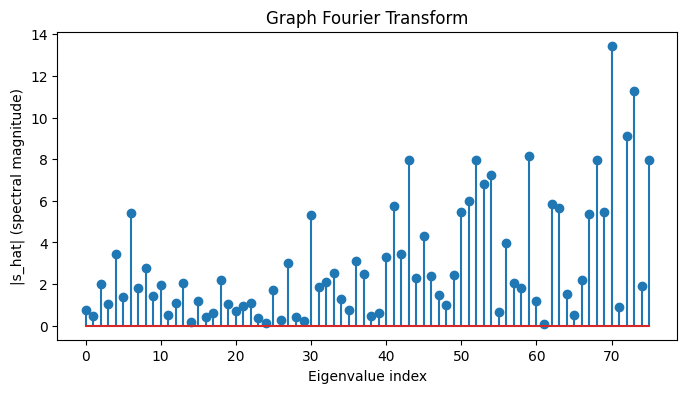

In [24]:
draw_frequency_spatial_signal(weather_processor, 15, "MEAN_2M")

Let's visualize the 'MEAN_2M' signal for different time periods on the weather station graph (GWS). We'll compare a winter month (period_id 15), a spring month (period_id 19), a summer month (period_id 22), and an autumn month (period_id 25).

Spectral properties on Weather Station Graph (GWS):

Winter (Period ID 15):
(76, 34)


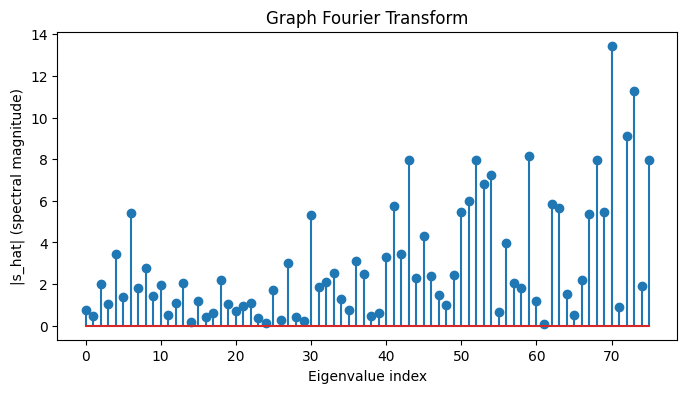


Spring (Period ID 19):
(76, 34)


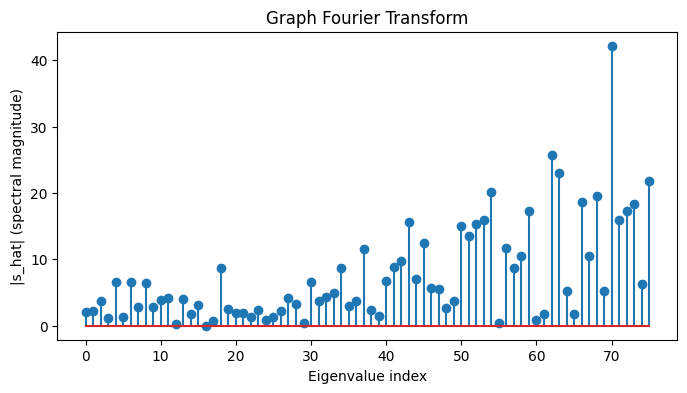


Summer (Period ID 22):
(76, 34)


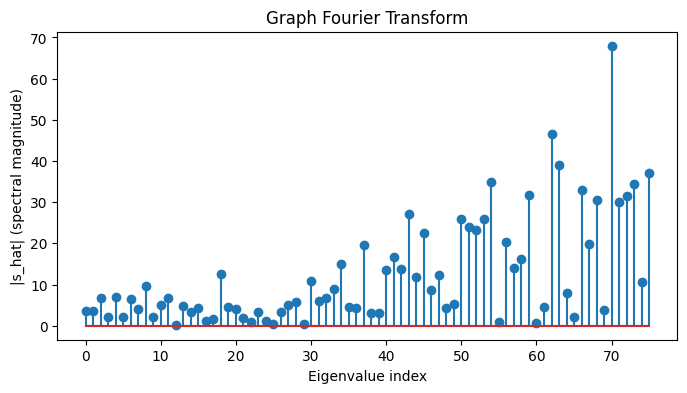


Autumn (Period ID 25):
(76, 34)


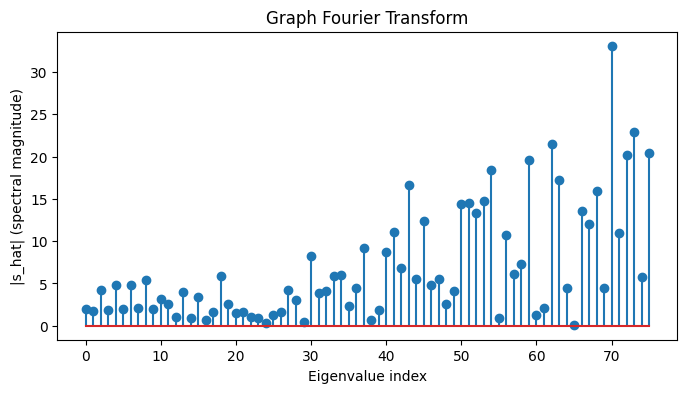

In [25]:
# Define period IDs for different seasons
winter_period_id = 15 # December
spring_period_id = 19 # April
summer_period_id = 22 # July
autumn_period_id = 25 # October

# Draw for each season on GWS
print("Spectral properties on Weather Station Graph (GWS):")

print("\nWinter (Period ID 15):")
draw_frequency_spatial_signal(weather_processor, winter_period_id, "MEAN_2M")

print("\nSpring (Period ID 19):")
draw_frequency_spatial_signal(weather_processor, spring_period_id, "MEAN_2M")

print("\nSummer (Period ID 22):")
draw_frequency_spatial_signal(weather_processor, summer_period_id, "MEAN_2M")

print("\nAutumn (Period ID 25):")
draw_frequency_spatial_signal(weather_processor, autumn_period_id, "MEAN_2M")

Visualization of the 'MEAN_2M' signal on the spatio-temporal graph (G_time_WS).

In [26]:
def draw_frequency_spatio_temp_signal(self, measurement):
    G_prod = construct_spacetime_graph(self)
    signal = get_signal_vec(self,  measurement)
    s_hat = graph_fourier_transform(self, signal, G_prod)
    plt.figure(figsize=(12, 6))
    plt.stem(np.arange(len(s_hat)), np.abs(s_hat))
    plt.xlabel("Eigenvalue index (Spatio-Temporal)")
    plt.ylabel("|s_hat| (spectral magnitude)")
    plt.title("Graph Fourier Transform of MEAN_2M on Spatio-Temporal Graph")
    plt.show()


Spatio-Temporal Graph (G_time_WS):
Constructed spatio-temporal graph with 2584 nodes


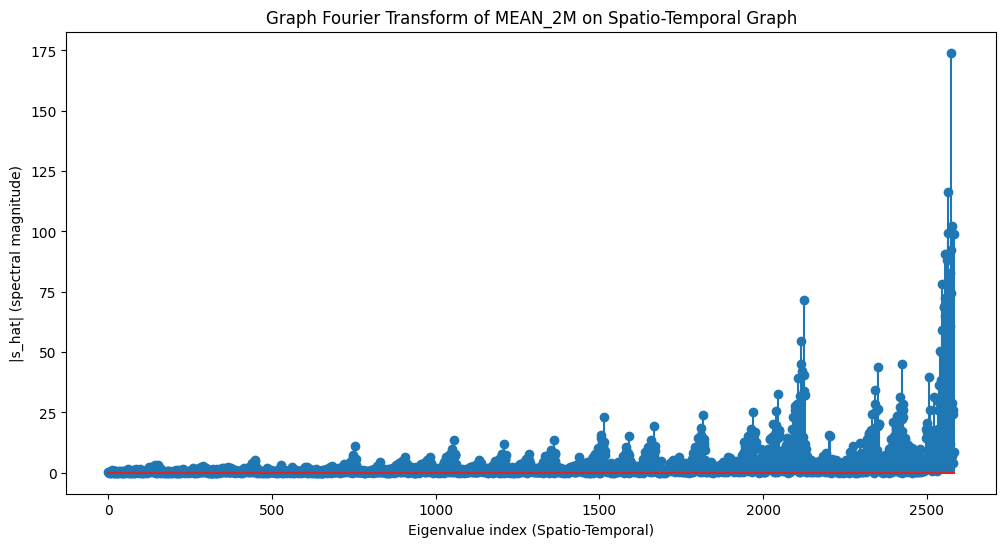

In [27]:
print("\nSpatio-Temporal Graph (G_time_WS):")
draw_frequency_spatio_temp_signal(weather_processor, "MEAN_2M" )

Applying a low-pass or high-pass filter by setting the spectral components corresponding to certain eigenvalues to zero.

In [33]:
def apply_spectral_filter(self, signal, A, filter_type, threshold):
    M, W = np.linalg.eigh(A)
    s_hat = W.T @ signal

    filtered_s_hat = s_hat.copy()

    if filter_type == 'lowpass':
        # Keep components with eigenvalues below the threshold
        filtered_s_hat[M > threshold] = 0
    elif filter_type == 'highpass':
        # Keep components with eigenvalues above the threshold
        filtered_s_hat[M <= threshold] = 0

    filtered_signal = W @ filtered_s_hat
    return filtered_signal

Appplying a filter to the 'MEAN_2M' signal for a specific time period and visualizing the original and filtered signals on the weather station graph.

(76, 34)


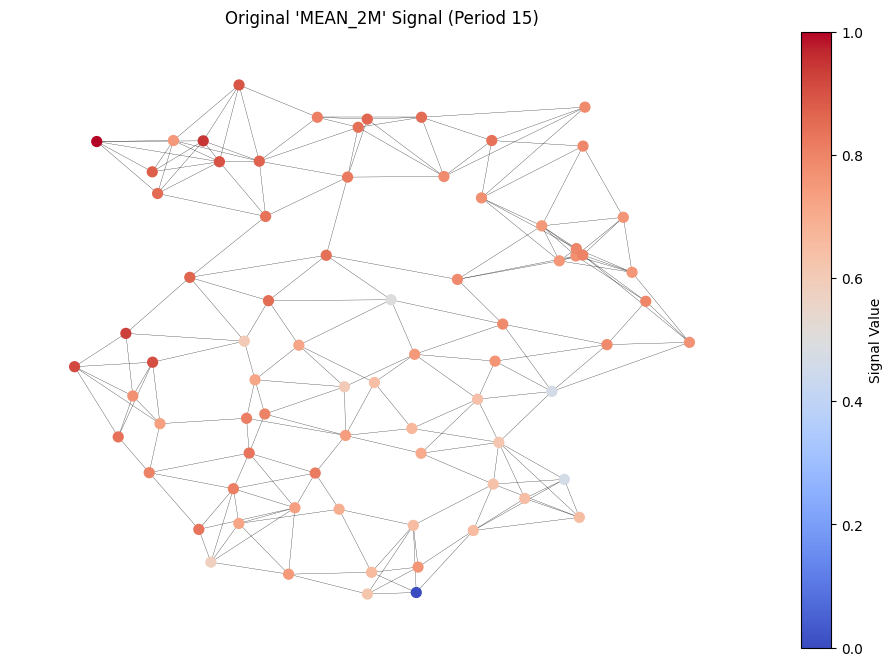

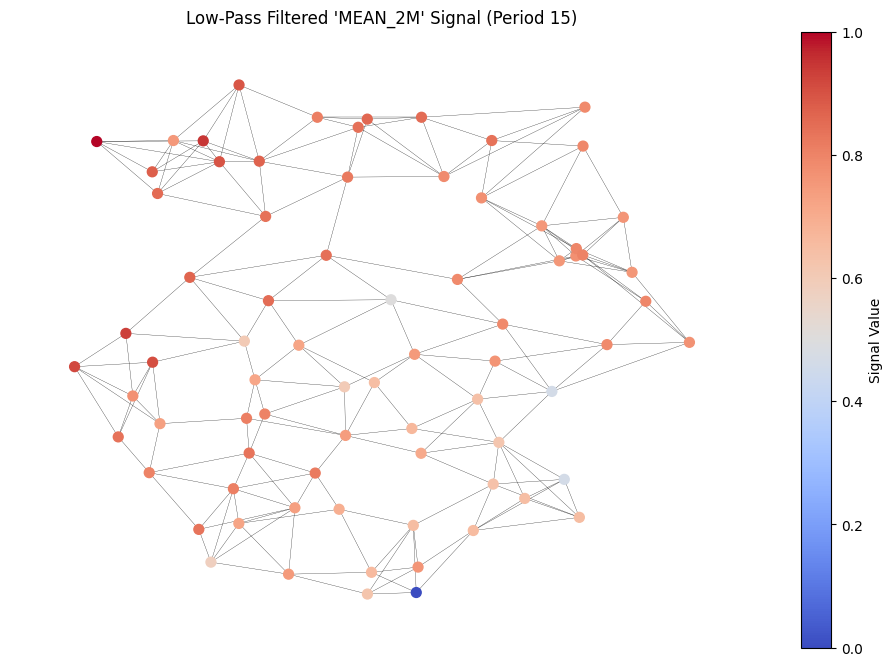

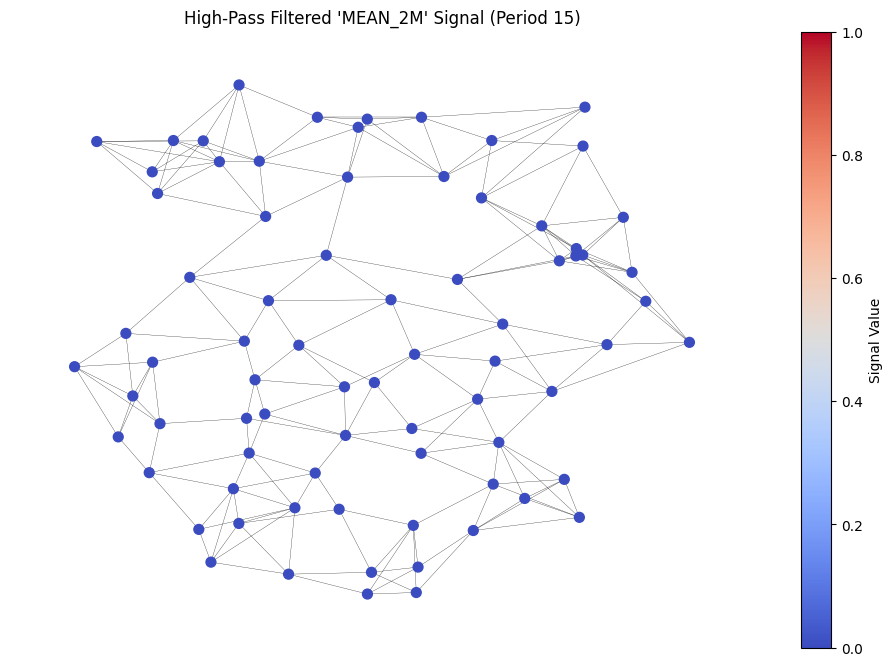

In [64]:
def draw_signal_on_graph(self, signal, title):
    G = nx.from_numpy_array(self.GWS)
    pos = {i: (self.stations_df['LONG'][i], self.stations_df['LAT'][i]) for i in range(len(self.stations_df))}
    fig, ax = plt.subplots(figsize=(12, 8))
    # Use the signal values for node coloring
    node_colors = signal
    cmap = plt.cm.coolwarm

    nx.draw(G, pos, node_size=50, width=0.2, node_color=node_colors, cmap=cmap, with_labels=False, ax=ax)
    plt.title(title)
    plt.colorbar(plt.cm.ScalarMappable(cmap=cmap), ax=ax, label="Signal Value")
    plt.show()

# Choose a period ID and measurement
period_id_to_filter = 15 # Choose period
measurement_to_filter = "MEAN_2M"

# Get the original spatial signal
original_signal = spatial_signal(weather_processor, period_id_to_filter, measurement_to_filter)

# Apply a low-pass filter
filtered_signal_lowpass = apply_spectral_filter(weather_processor, original_signal, weather_processor.GWS, filter_type='lowpass', threshold=0.5)

# Apply a high-pass filter
filtered_signal_highpass = apply_spectral_filter(weather_processor, original_signal, weather_processor.GWS, filter_type='highpass', threshold=10)


# Draw the original and filtered signals
draw_signal_on_graph(weather_processor, original_signal, f"Original '{measurement_to_filter}' Signal (Period {period_id_to_filter})")
draw_signal_on_graph(weather_processor, filtered_signal_lowpass, f"Low-Pass Filtered '{measurement_to_filter}' Signal (Period {period_id_to_filter})")
draw_signal_on_graph(weather_processor, filtered_signal_highpass, f"High-Pass Filtered '{measurement_to_filter}' Signal (Period {period_id_to_filter})")

(76, 34)


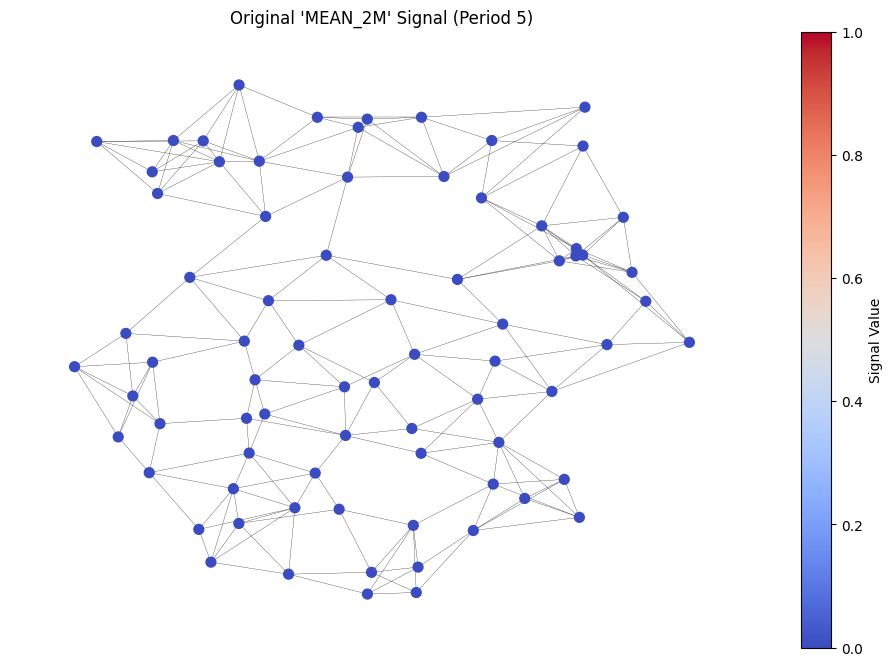

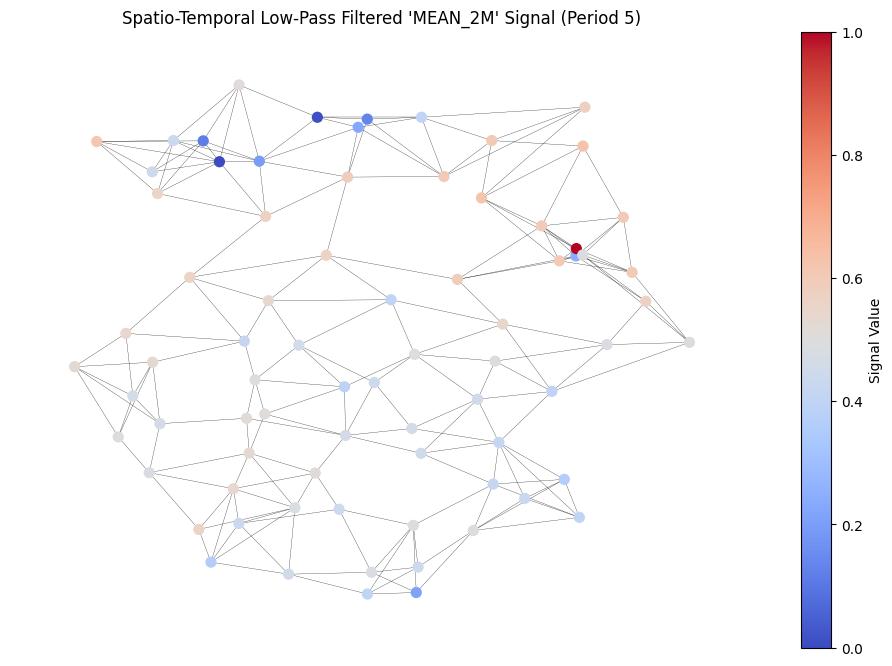

In [74]:
# Construct the spatio-temporal graph

# Get the spatio-temporal signal vector
spatio_temporal_signal = get_signal_vec(weather_processor, "MEAN_2M")

# Apply a filter to the spatio-temporal signal
filtered_spatio_temporal_signal_lowpass = apply_spectral_filter(
    weather_processor,
    spatio_temporal_signal,
    G_time_WS,
    filter_type='lowpass', # or highpass
    threshold=0.1
)

# Reshape the filtered spatio-temporal signal back into a spatial-temporal matrix
n_stations = len(weather_processor.stations_df)
time_steps = weather_processor.G_P.number_of_nodes()
filtered_signal_matrix_lowpass = filtered_spatio_temporal_signal_lowpass.reshape((n_stations, time_steps))

# Choose a specific time period to visualize the filtered spatial signal
period_to_visualize = 5

# Get the original spatial signal for comparison
original_spatial_signal = spatial_signal(weather_processor, period_to_visualize, "MEAN_2M")

# Get the filtered spatial signal for the chosen period
filtered_spatial_signal_lowpass = filtered_signal_matrix_lowpass[:, period_to_visualize]

# Draw the original spatial signal
draw_signal_on_graph(
    weather_processor,
    original_spatial_signal,
    f"Original 'MEAN_2M' Signal (Period {period_to_visualize})"
)

# Draw the filtered spatial signal on the weather station graph
draw_signal_on_graph(
    weather_processor,
    filtered_spatial_signal_lowpass,
    f"Spatio-Temporal Low-Pass Filtered 'MEAN_2M' Signal (Period {period_to_visualize})"
)